# Electrophysiology analysis
This notebook will walk through the basic analysis of LFP and spike data during the virtual foraging task. It uses data that has already been preprocessed in the `ephys_preprocessing` notebook.

## Table of contents
- [Spike analysis](#spike-analysis)
    - [Load spike data](#load-spike-data)
    - [Plot spike raster](#spike-raster)
    - [Create smoothing kernel](#smoothing-kernel)
    - [Peri-leaving activity](#peri-leaving)
    - [Peri-moving activity](#peri-moving)
    - [Peri-entering activity](#peri-entering)
    - [Peri-reward activity](#peri-reward)
    - [Peri-lick activity](#peri-lick)
    - [Individual unit analysis](#individual-unit)
- [LFP analysis](#lfp-analysis)

## Initial setup

### Imports

In [1]:
# General
import os
import sys
import json
import struct
from time import time
import tempfile
import getpass

# Analysis
import numpy as np
import math
from scipy.interpolate import interp1d

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Code
sys.path.insert(0, '../python/')
from session import Session, FreeSession
import util
import ephys
import analysis
from plot import Plotter

### Settings

In [2]:
### Directories ###
# Behavior data
#labview_filepath = 'Y:/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
labview_filepath = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/labview/j6z4_d25_2019_02_04_16_29_34.mat'
sess_filepath = None

# Raw ephys data
#raw_dir = 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'
raw_dir = '/media/james/mcginley_server_3/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'

# Preprocessed ephys data (Google Drive API)
pre_dir = '/media/james/data/foraging/ephys/02-04-19/spike_sorting/mountainsort/shank_1/' # preprocessed data directory
timeseries_filepath = pre_dir + 'original/raw_w.mda'
firings_filepath = pre_dir + 'curation_1/firings_final.mda'
cluster_metrics_filepath = pre_dir + 'curation_1/metrics_curated_tagged.json'

# Other ephys data
timestamps_filepath = '/media/james/data/foraging/ephys/02-04-19/general/timestamps_daq_clock.npy'
use_google_drive = False # if true, find files in Google Drive
storage_mode = 1 # 0 = read from server, 1 = download to local disk, 2 = load in memory

results_dir = '/media/james/data/foraging/ephys/02-04-19/analysis/shank_1/' # directory to store downloads

In [ ]:
# Allow read/write permissions from directory
password = getpass.getpass()
command = 'sudo -S chmod 777 %s' % results_dir # -S enables input from stdin
os.system('echo %s | %s' % (password, command));

### Load behavior data

In [4]:
# Session data
sess = FreeSession(labview_filepath)
if sess_filepath is not None:
    sess.load(sess_filepath)
    
# Wheel data
t_wheel = sess.get_wheel_times() # timestamps aligned to sound
v_wheel = sess.data['wheel_speed']
fs_wheel = 1.0 / 0.005 # hard-coded 5 ms sampling rate

### Load objects

In [5]:
plot = Plotter()

## Spike analysis <a id="spike-analysis"></a>

### Load spike data <a id="load-spike-data"></a>

In [6]:
# Load data
if use_google_drive:
    # Create Service object
    drive_service = util.GoogleDriveService()
    
    # Load spike data
    print('Loading spike data...', end=' ')
    firings = util.bytes_to_object(drive_service.download(filename=firings_filepath), ob_type='numpy')
    print('done.')
    
    # Load Intan timestamps
    print('Loading Intan timestamps...', end=' ')
    t_intan = util.bytes_to_object(drive_service.download(filename=timestamps_filepath), ob_type='numpy')
    t_firings = t_intan[firings[1, :].astype(np.int32)]
    print('done.')
    
    # Load File object for reading timeseries MDA file
    print('Creating File object for timeseries MDA file...', end=' ')
    if storage_mode == 0:
        # To save storage, can continually read from server, but this can be prohibitively slow
        # if many reads are required
        drive_file = util.GoogleDriveFile(drive_service, timeseries_filepath)
        timeseries_reader = util.MDAReader(drive_file)
    elif storage_mode == 1:
        # Faster to download entire file and store on hard disk, but files can be large (~50+ GB)
        if not os.path.exists(media_dir + timeseries_filepath):
            f = open(media_dir + timeseries_filepath, 'w+b')
            drive_service.download(filename=timeseries_filepath, file_object=f)
            f.seek(0, 0) # reset pointer to beginning of file
        else:
            f = open(media_dir + timeseries_filepath, 'rb')
        timeseries_reader = util.MDAReader(f)
    elif storage_mode == 2:
        # Fastest to load entirely in memory
        f = io.BytesIO(drive_service.download(filename=timeseries_filepath))
        timeseries_reader = util.MDAReader(f)
    else:
        raise SyntaxError('Unknown storage mode %d.' % storage_mode)
    print('done.')
        
    # Load cluster metrics
    cluster_metrics = util.bytes_to_object(drive_service.download(filename=cluster_metrics_filepath), ob_type='json')
    
else:
    # Load spike data
    print('Loading spike data...', end=' ')
    with open(firings_filepath, 'rb') as f:
        firings = util.MDAReader(f).read()
    print('done.')
    
    # Load Intan timestamps
    print('Loading Intan timestamps...', end=' ')
    t_intan = np.load(timestamps_filepath)
    t_firings = t_intan[firings[1, :].astype(np.int32)]
    print('done.')
    
    # Load File object for reading timeseries MDA file
    print('Creating File object for timeseries MDA file...', end=' ')
    if storage_mode in [0, 1]:
        timeseries_reader = util.MDAReader(open(timeseries_filepath, 'rb'))
    elif storage_mode == 2:
        timeseries_reader = io.BytesIO(open(timeseries_filepath, 'rb'))
    print('done.')
    
    # Load cluster metrics
    print('Loading cluster metrics...', end=' ')
    with open(cluster_metrics_filepath, 'r') as f:
        cluster_metrics = json.loads(f.read())
    print('done.')

Loading spike data... done.
Loading Intan timestamps... done.
Creating File object for timeseries MDA file... done.
Loading cluster metrics... done.


In [7]:
# Limit to active behavior
# t_intan[t] = -1 for all t not during active behavior
firings = firings[:, t_firings > 0.0]
t_firings = t_firings[t_firings > 0.0]

# Get cluster labels
cluster_labels = np.unique(firings[2, :]).astype(np.int32)

### Plot spike raster across session <a id="spike-raster"></a>

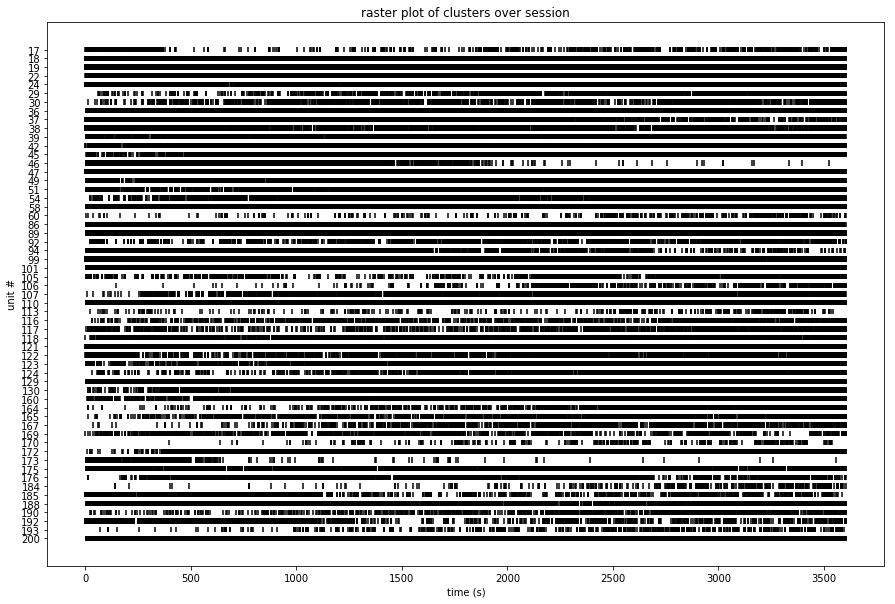

In [8]:
# Create figure
fig, ax = plt.subplots(figsize=(15, 10))

# Raster plot
for i, label in enumerate(cluster_labels):
    ax.vlines(t_firings[firings[2, :] == label], ymin=-(i-0.3), ymax=-(i+0.3))

# Plot settings
ax.set_yticks(-np.arange(len(cluster_labels)))
ax.set_yticklabels(cluster_labels)
ax.set_xlabel('time (s)')
ax.set_ylabel('unit #')
ax.set_title('raster plot of clusters over session');

### Create smoothing kernel <a id="smoothing-kernel"></a>

In [9]:
# Kernel settings
kernel_type = 'Gaussian'
dt_bin = 0.020 # bin size (s)
sigma = 0.150 # kernel width (ms)

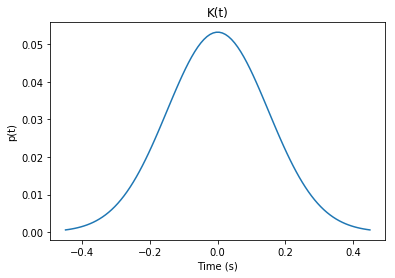

In [10]:
# Create kernel
kernel = ephys._create_smoothing_kernel(kernel_type, 
                                        dt_bin, 
                                        sigma=sigma)

# Plot kernel over +/- 3 standard deviations
sigma_k = sigma / dt_bin
x = np.linspace(-3*sigma_k, 3*sigma_k, num=100)
fig, ax = plt.subplots()
ax.plot(x*dt_bin, kernel(x))
ax.set_title('K(t)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('p(t)');

### Peri-leaving activity <a id="peri-leaving"></a>

#### Settings

In [11]:
window = [-10.0, 10.0] # window around leaving decision
min_dt_patch = abs(window[0])

#### Get firing rates

In [12]:
# Get leaving times
print('Getting patch times...', end=' ')
t_patch = sess.get_patch_times()
dt_patch = sess.get_patch_durations()
dt_ip = sess.get_interpatch_durations()
print('done.')

# Session statistics
print('Number of patches: %d' % t_patch.shape[0])
print('Residence times: %.2f +/- %.2f' % (np.mean(dt_patch), np.std(dt_patch)))
print('Travel times: %.2f +/- %.2f' % (np.mean(dt_ip), np.std(dt_ip)))

# Filter by window size
t_leave = t_patch[:, 1]
t_leave = t_leave[dt_patch > min_dt_patch]
print('Found %d analyzable leaving times.' % len(t_leave))

Getting patch times... done.
Number of patches: 52
Residence times: 61.08 +/- 63.87
Travel times: 8.16 +/- 4.29
Found 45 analyzable leaving times.


In [13]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_leave,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin = n_bin / dt_bin
f_smooth = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.516 seconds)
Processing unit 18 (2 of 57)... done. (5.750 seconds)
Processing unit 19 (3 of 57)... done. (4.314 seconds)
Processing unit 22 (4 of 57)... done. (2.904 seconds)
Processing unit 24 (5 of 57)... done. (2.767 seconds)
Processing unit 29 (6 of 57)... done. (1.121 seconds)
Processing unit 30 (7 of 57)... done. (0.751 seconds)
Processing unit 36 (8 of 57)... done. (3.724 seconds)
Processing unit 37 (9 of 57)... done. (1.766 seconds)
Processing unit 38 (10 of 57)... done. (2.072 seconds)
Processing unit 39 (11 of 57)... done. (1.431 seconds)
Processing unit 42 (12 of 57)... done. (4.930 seconds)
Processing unit 45 (13 of 57)... done. (1.859 seconds)
Processing unit 46 (14 of 57)... done. (1.581 seconds)
Processing unit 47 (15 of 57)... done. (6.283 seconds)
Processing unit 49 (16 of 57)... done. (1.746 seconds)
Processing unit 51 (17 of 57)... done. (1.946 seconds)
Processing unit 54 (18 of 57)... done. (1.841 seconds)
Processing unit 58 

../python/ephys.py:489: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  k_i = k(idx)[[np.newaxis]*a + [slice(None)] + [np.newaxis]*b]
../python/ephys.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x_smooth[slc] = np.sum(k_i * x, axis=axis)


In [14]:
# Save firing rates
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'f_smooth': f_smooth,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_leave.npy', d)
print('done.')

Saving firings rates... done.


#### Get time-aligned data
This should include wheel velocity and pupil diameter, when both become available.

Note: These are estimated because the wheel data is not sampled uniformly. However, getting exact times across multiple windows is difficult, because each sample may be off by +/- 1 ms.

In [29]:
# Get raw velocity traces and timestamps corresponding to stimulus windows
t_wheel_leave, v_wheel_leave = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_patch[:, 1], 
                               window=window, 
                               fs=fs_wheel)

#### Plot firing rates
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

TODO: maybe use autocorrelation coefficient to search for non-randomness in curves?

In [32]:
# Load firing data
print('Loading firing data...', end=' ')
d = np.load(results_dir + 'firing_rates_leave.npy')[()]
f_smooth = d.pop('f_smooth')
bins = d.pop('bins')
cluster_labels = d.pop('labels')
print('done.')

Loading firing data... done.


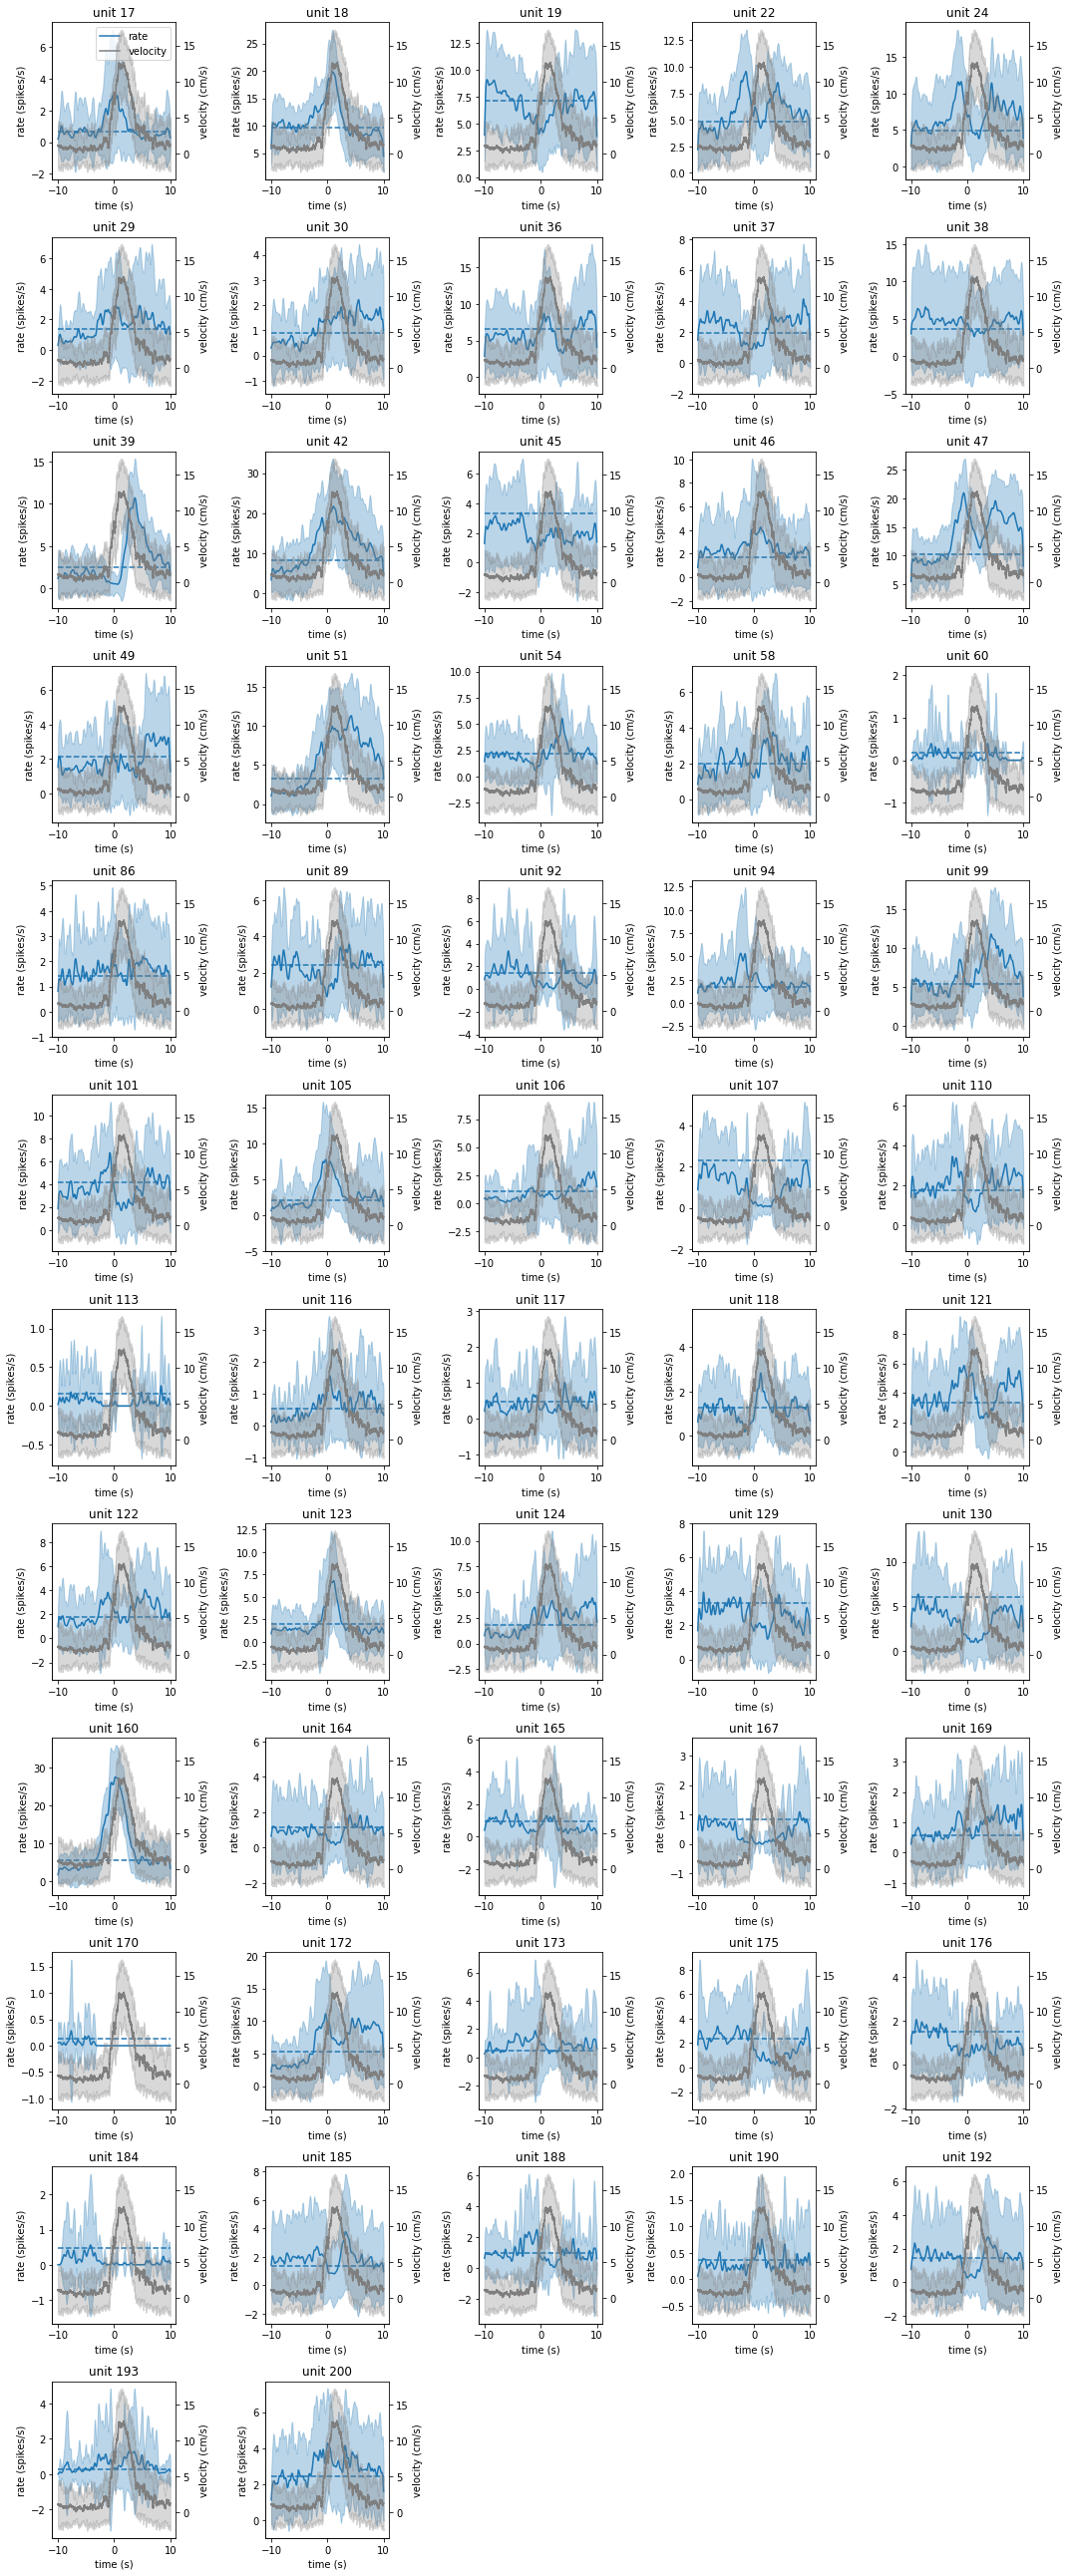

In [33]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})

# Plot PSTH
plotter.plot_psth(counts=np.mean(f_smooth, axis=1),
                  bins=bins,
                  dt_bin=dt_bin,
                  err=np.std(f_smooth, axis=1),
                  labels=cluster_labels,
                  metrics=cluster_metrics,
                  color='C0',
                  label='rate')

# Plot time-aligned wheel velocity
plotter.add_trace(t_wheel_leave, 
                  np.mean(v_wheel_leave, axis=0), 
                  err=np.std(v_wheel_leave, axis=0), 
                  twinx=True, 
                  y_label='velocity (cm/s)', 
                  all_axes=True,
                  color='C7',
                  label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False)

# Save figure
plt.savefig(results_dir + 'peri_leaving_activity.pdf')

### Peri-moving activity <a id="peri-moving"></a>
This is movement *not* associated with patch-leaving. In other words, it occurs when the animal begins to run after having stopped in an interpatch before covering the interpatch distance.

#### Settings

In [34]:
window = [-10.0, 10.0] # window around leaving decision
min_dt_patch = abs(window[0])

#### Get firing rates

In [35]:
t_move = analysis.get_interpatch_move_times(sess)

print('Found %d analyzable interpatch movement time(s).' % len(t_move))

Found 1 analyzable interpatch movement time(s).


In [36]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_move,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin = n_bin / dt_bin
f_smooth = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.012 seconds)
Processing unit 18 (2 of 57)... done. (0.132 seconds)
Processing unit 19 (3 of 57)... done. (0.092 seconds)
Processing unit 22 (4 of 57)... done. (0.059 seconds)
Processing unit 24 (5 of 57)... done. (0.056 seconds)
Processing unit 29 (6 of 57)... done. (0.018 seconds)
Processing unit 30 (7 of 57)... done. (0.012 seconds)
Processing unit 36 (8 of 57)... done. (0.070 seconds)
Processing unit 37 (9 of 57)... done. (0.028 seconds)
Processing unit 38 (10 of 57)... done. (0.040 seconds)
Processing unit 39 (11 of 57)... done. (0.028 seconds)
Processing unit 42 (12 of 57)... done. (0.112 seconds)
Processing unit 45 (13 of 57)... done. (0.025 seconds)
Processing unit 46 (14 of 57)... done. (0.025 seconds)
Processing unit 47 (15 of 57)... done. (0.132 seconds)
Processing unit 49 (16 of 57)... done. (0.029 seconds)
Processing unit 51 (17 of 57)... done. (0.036 seconds)
Processing unit 54 (18 of 57)... done. (0.030 seconds)
Processing unit 58 

../python/ephys.py:489: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  k_i = k(idx)[[np.newaxis]*a + [slice(None)] + [np.newaxis]*b]
../python/ephys.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x_smooth[slc] = np.sum(k_i * x, axis=axis)


In [37]:
# Save firing rates
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'f_smooth': f_smooth,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_move.npy', d)
print('done.')

Saving firings rates... done.


#### Get time-aligned data
This should include wheel velocity and pupil diameter, when both become available.

In [38]:
# Get raw velocity traces and timestamps corresponding to stimulus windows
t_wheel_move, v_wheel_move = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_move, 
                               window=window, 
                               fs=fs_wheel)

#### Plot firing rates
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

TODO: maybe use autocorrelation coefficient to search for non-randomness in curves?

In [39]:
# Load firing data
print('Loading firing data...', end=' ')
d = np.load(results_dir + 'firing_rates_move.npy')[()]
f_smooth = d.pop('f_smooth')
bins = d.pop('bins')
cluster_labels = d.pop('labels')
print('done.')

Loading firing data... done.


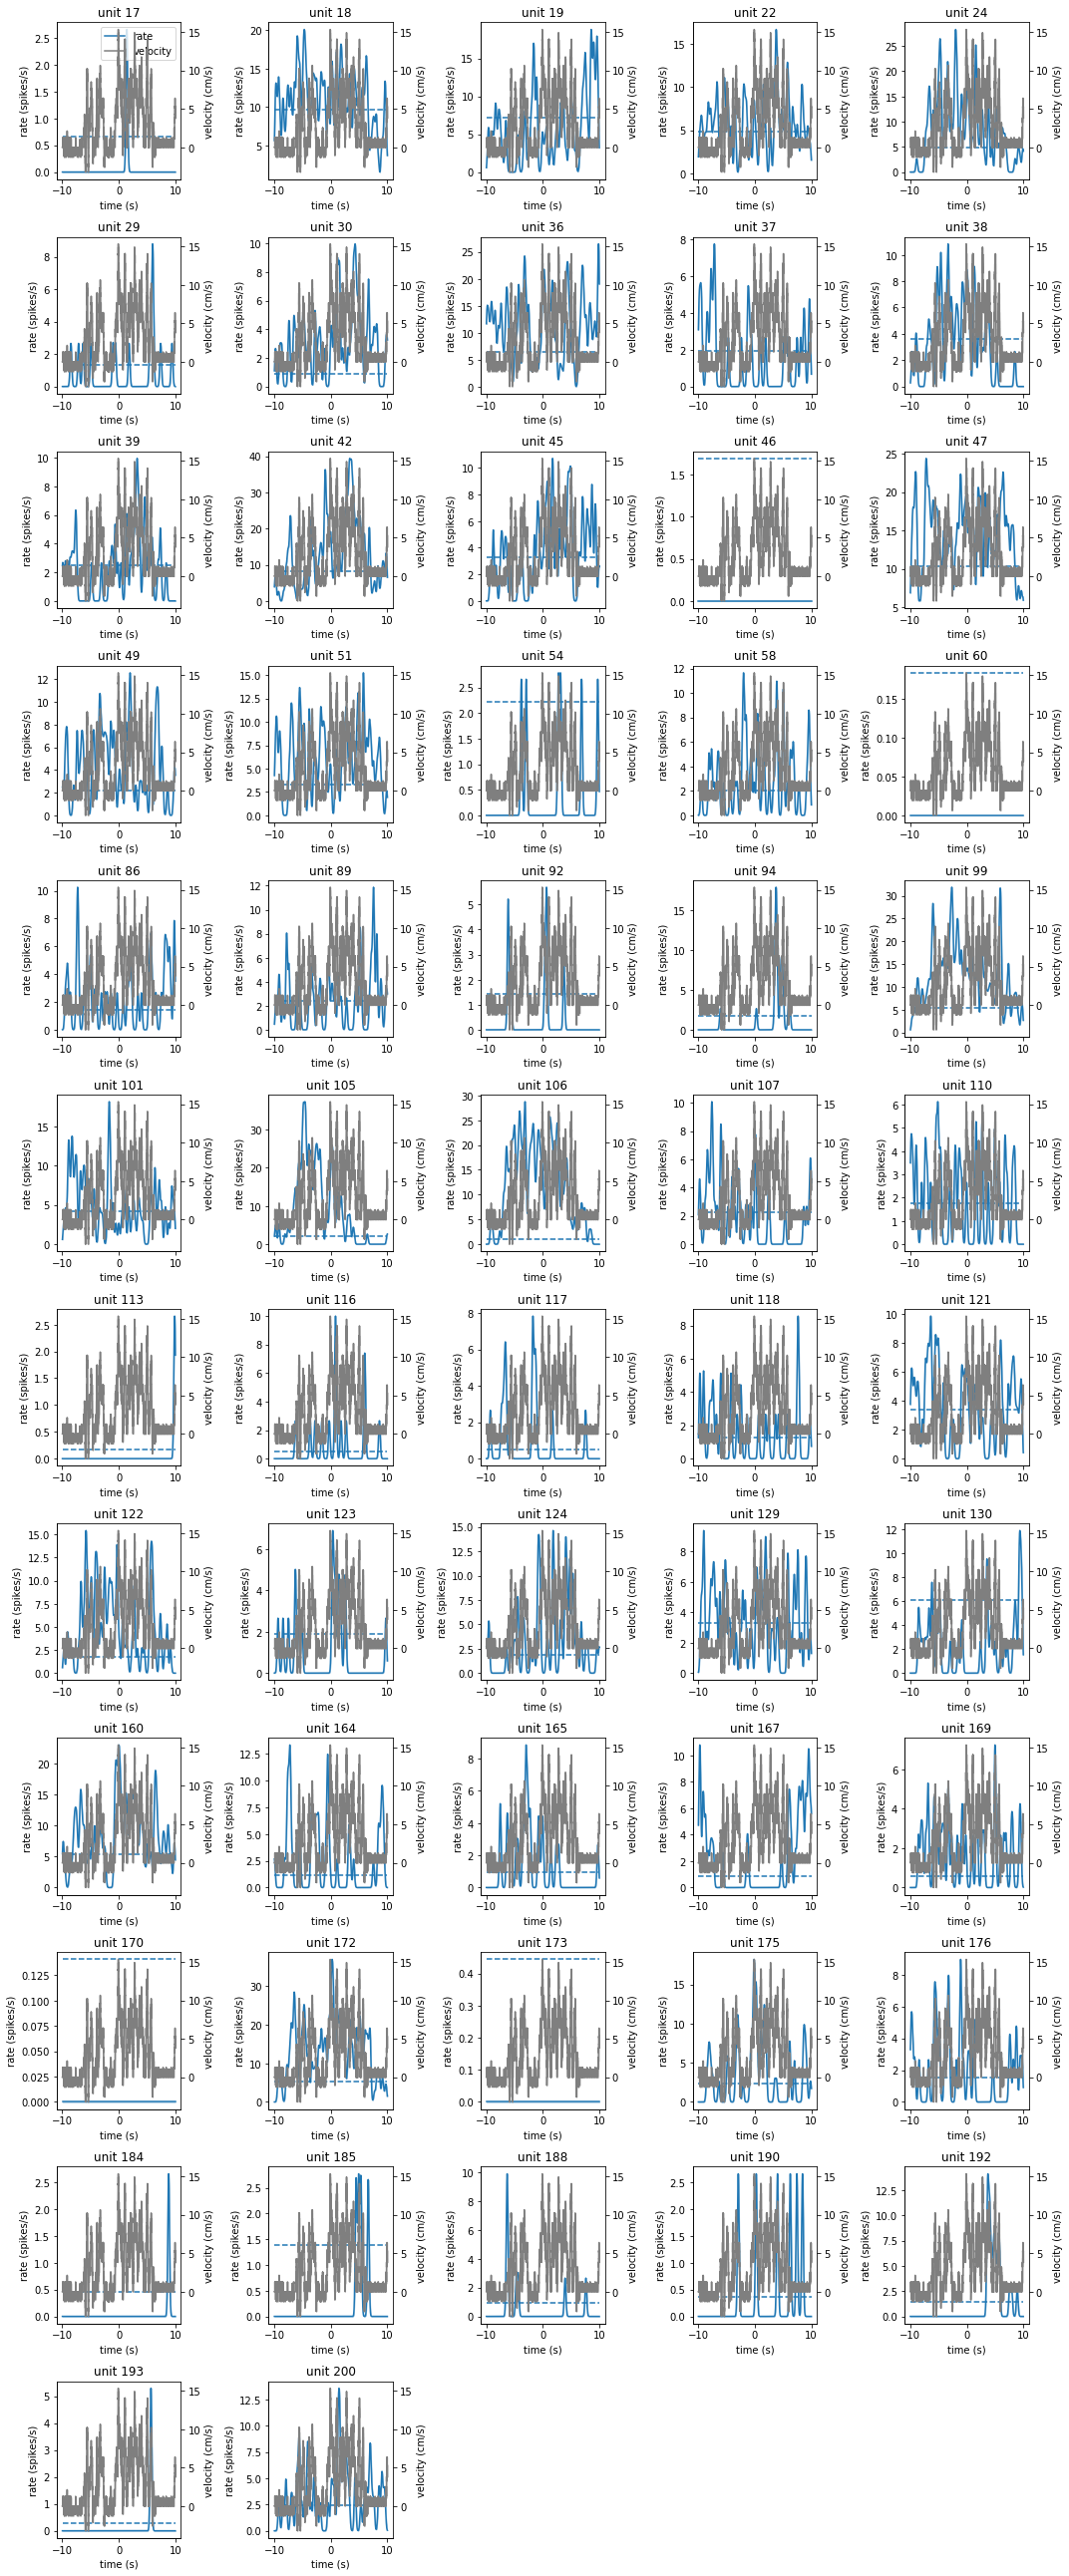

In [42]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})

# Plot PSTH
plotter.plot_psth(counts=np.mean(f_smooth, axis=1),
              bins=bins,
              dt_bin=dt_bin,
              err=np.std(f_smooth, axis=1),
              labels=cluster_labels,
              metrics=cluster_metrics,
              color='C0',
              label='rate')

# Plot time-aligned wheel velocity
plotter.add_trace(t_wheel_move, 
               np.mean(v_wheel_move, axis=0), 
               err=np.std(v_wheel_move, axis=0), 
               twinx=True, 
               y_label='velocity (cm/s)', 
               all_axes=True,
               color='C7',
               label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False, loc=1)

# Save figure
plt.savefig(results_dir + 'peri_moving_activity.pdf')

### Peri-enter activity <a id="peri-entering"></a>

#### Settings

In [43]:
window = [-5.0, 5.0] # window around entering decision
dt_bin = 0.020 # bin size (s)
min_dt_interpatch = abs(window[0])

#### Get firing rates

In [44]:
# Get entering times
print('Getting patch times...', end=' ')
t_patch = sess.get_patch_times()
dt_patch = sess.get_patch_durations()
dt_interpatch = sess.get_interpatch_durations()
print('done.')

# Session statistics
print('Number of patches: %d' % t_patch.shape[0])
print('Residence times: %.2f +/- %.2f' % (np.mean(dt_patch), np.std(dt_patch)))
print('Travel times: %.2f +/- %.2f' % (np.mean(dt_ip), np.std(dt_ip)))

# Filter by window size
t_enter = t_patch[1:, 0]
t_enter = t_enter[dt_interpatch[:-1] > min_dt_interpatch]
print('Found %d analyzable enter times.' % len(t_enter))

Getting patch times... done.
Number of patches: 52
Residence times: 61.08 +/- 63.87
Travel times: 8.16 +/- 4.29
Found 46 analyzable enter times.


In [45]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_enter,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin = n_bin / dt_bin
f_smooth = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.292 seconds)
Processing unit 18 (2 of 57)... done. (2.969 seconds)
Processing unit 19 (3 of 57)... done. (2.254 seconds)
Processing unit 22 (4 of 57)... done. (1.508 seconds)
Processing unit 24 (5 of 57)... done. (1.427 seconds)
Processing unit 29 (6 of 57)... done. (0.556 seconds)
Processing unit 30 (7 of 57)... done. (0.381 seconds)
Processing unit 36 (8 of 57)... done. (1.895 seconds)
Processing unit 37 (9 of 57)... done. (0.892 seconds)
Processing unit 38 (10 of 57)... done. (1.077 seconds)
Processing unit 39 (11 of 57)... done. (0.742 seconds)
Processing unit 42 (12 of 57)... done. (2.477 seconds)
Processing unit 45 (13 of 57)... done. (0.915 seconds)
Processing unit 46 (14 of 57)... done. (0.792 seconds)
Processing unit 47 (15 of 57)... done. (3.183 seconds)
Processing unit 49 (16 of 57)... done. (0.903 seconds)
Processing unit 51 (17 of 57)... done. (1.004 seconds)
Processing unit 54 (18 of 57)... done. (0.949 seconds)
Processing unit 58 

In [46]:
# Save firing rates
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'f_smooth': f_smooth,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_enter.npy', d)
print('done.')

Saving firings rates... done.


#### Get time-aligned data
This should include wheel velocity and pupil diameter, when both become available.

Note: These are estimated because the wheel data is not sampled uniformly. However, getting exact times across multiple windows is difficult, because each sample may be off by +/- 1 ms.

In [47]:
# Get raw velocity traces and timestamps corresponding to stimulus windows
t_wheel_enter, v_wheel_enter = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_enter, 
                               window=window, 
                               fs=fs_wheel)

#### Plot firing rates
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

TODO: maybe use autocorrelation coefficient to search for non-randomness in curves?

In [48]:
# Load firing data
print('Loading firing data...', end=' ')
d = np.load(results_dir + 'firing_rates_enter.npy')[()]
f_smooth = d.pop('f_smooth')
bins = d.pop('bins')
cluster_labels = d.pop('labels')
print('done.')

Loading firing data... done.


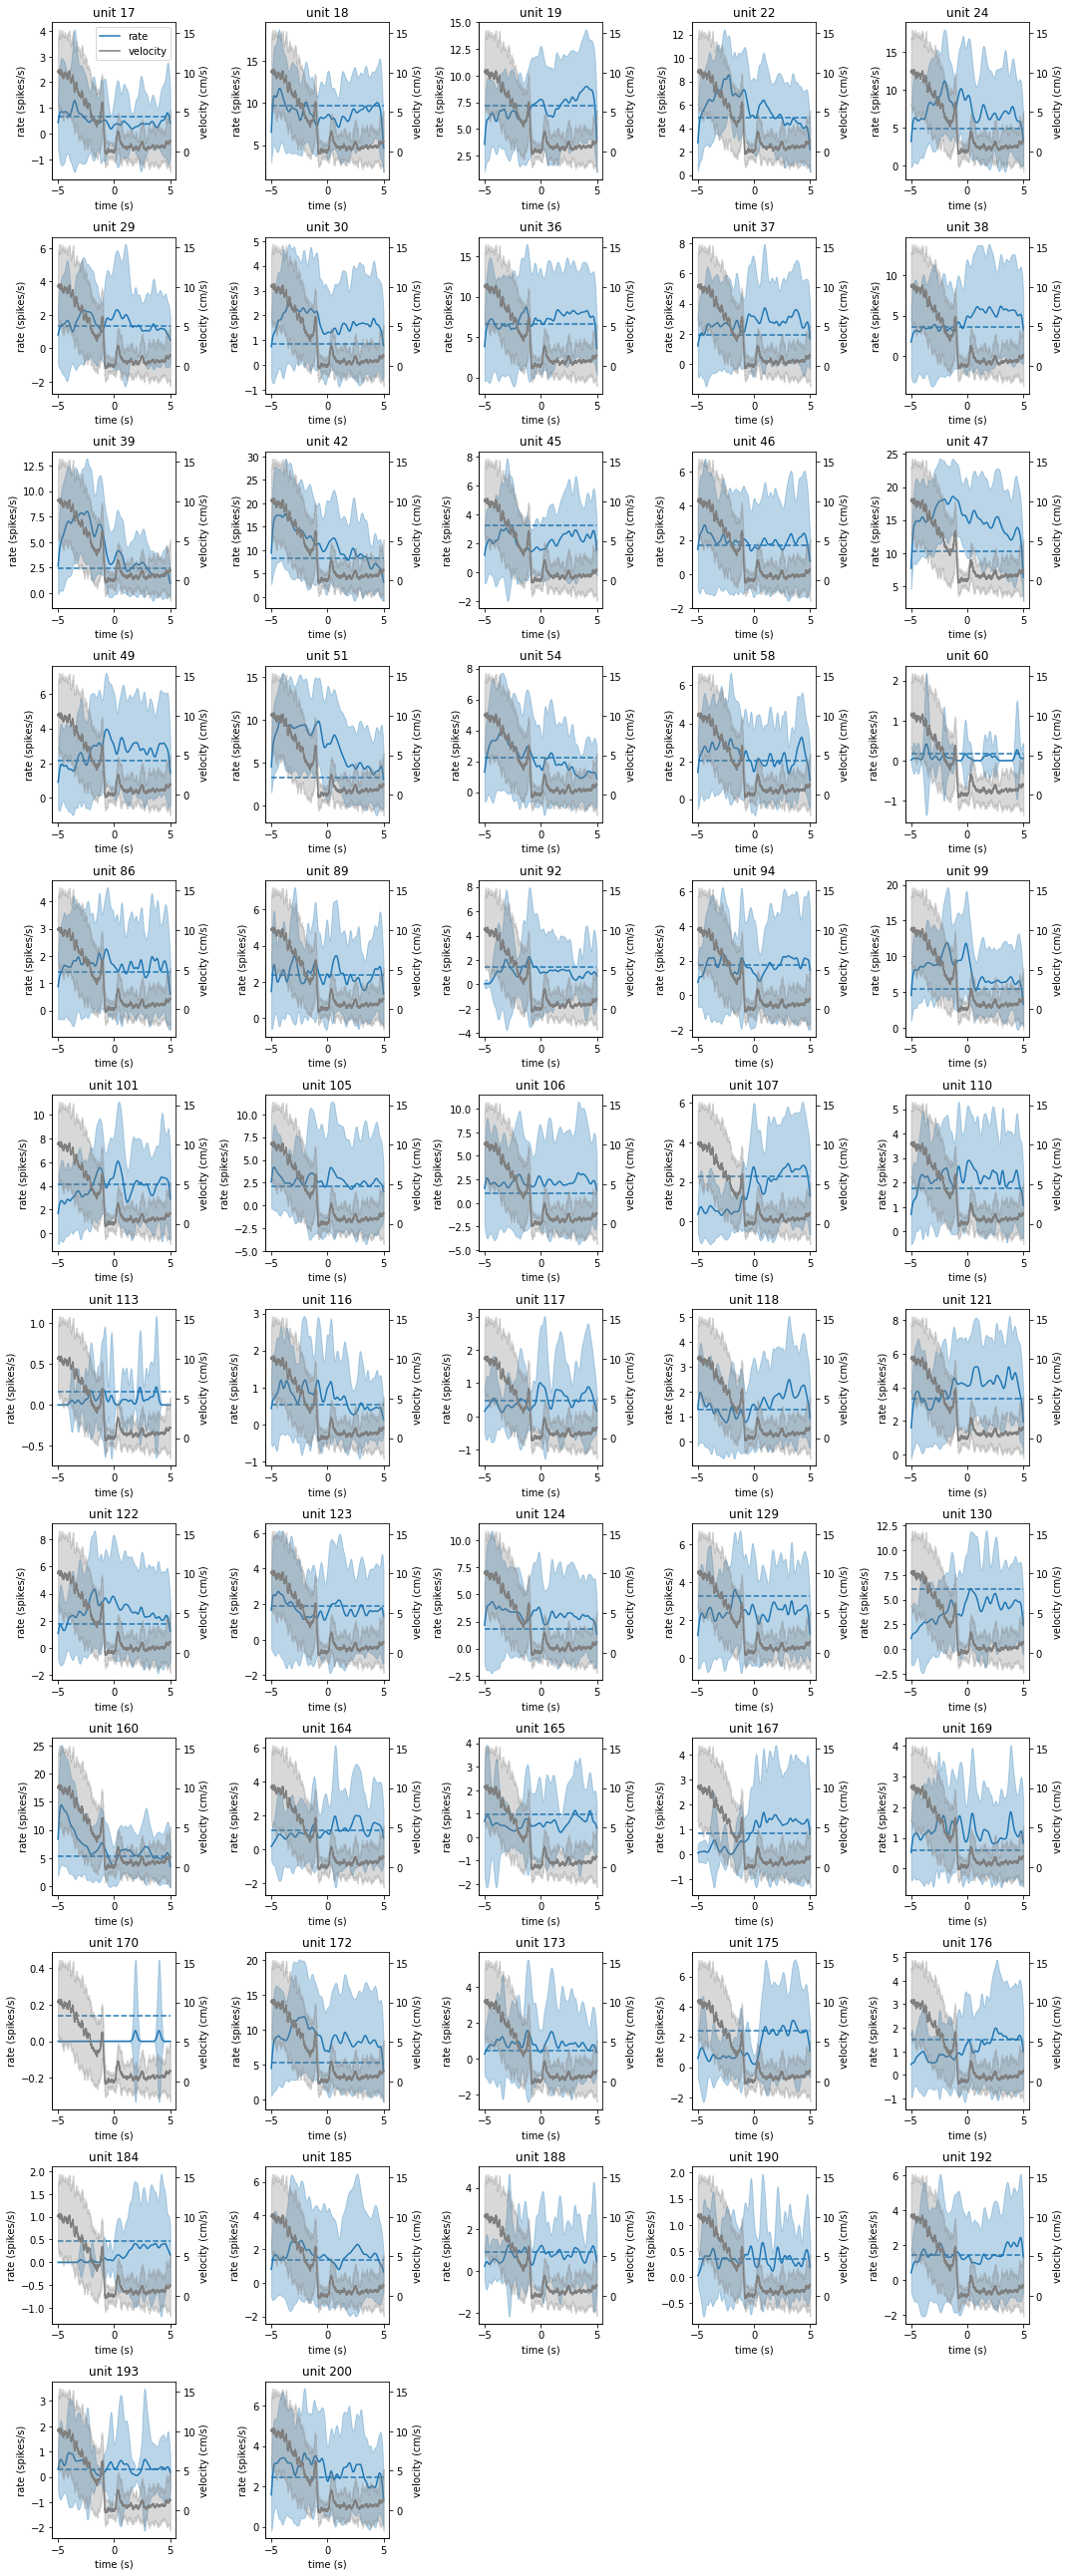

In [49]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})

# Plot PSTH
plotter.plot_psth(counts=np.mean(f_smooth, axis=1),
                  bins=bins,
                  dt_bin=dt_bin,
                  err=np.std(f_smooth, axis=1),
                  labels=cluster_labels,
                  metrics=cluster_metrics,
                  color='C0',
                  label='rate')

# Plot time-aligned wheel velocity
plotter.add_trace(t_wheel_enter, 
                  np.mean(v_wheel_enter, axis=0), 
                  err=np.std(v_wheel_enter, axis=0), 
                  twinx=True, 
                  y_label='velocity (cm/s)', 
                  all_axes=True,
                  color='C7',
                  label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False)

# Save figure
plt.savefig(results_dir + 'peri_enter_activity.pdf')

### Peri-reward activity <a id="peri-reward"></a>

#### Settings

In [50]:
window = [-2.0, 2.0] # window around entering decision
dt_bin = 0.020 # bin size (s)
min_dt_motor = abs(max(window))

#### Get firing rates around reward

In [51]:
# Get reward times
print('Getting reward times...', end=' ')
t_motor = sess.get_motor_times()
print('done.')

# Session statistics
print('Number of rewards: %d' % t_motor.shape[0])

# Filter by window size
idx_keep = np.ones(t_motor.shape, dtype=np.bool)
for i in range(t_motor.shape[0]-1):
    if idx_keep[i] and (t_motor[i+1] - t_motor[i]) < min_dt_motor:
        idx_keep[i+1] = False
t_motor = t_motor[idx_keep]
print('Found %d analyzable reward times.' % len(t_motor))

Getting reward times... done.
Number of rewards: 266
Found 266 analyzable reward times.


In [52]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_motor,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin = n_bin / dt_bin
f_smooth = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.599 seconds)
Processing unit 18 (2 of 57)... done. (6.915 seconds)
Processing unit 19 (3 of 57)... done. (5.165 seconds)
Processing unit 22 (4 of 57)... done. (3.512 seconds)
Processing unit 24 (5 of 57)... done. (3.293 seconds)
Processing unit 29 (6 of 57)... done. (1.288 seconds)
Processing unit 30 (7 of 57)... done. (0.882 seconds)
Processing unit 36 (8 of 57)... done. (4.405 seconds)
Processing unit 37 (9 of 57)... done. (2.062 seconds)
Processing unit 38 (10 of 57)... done. (2.483 seconds)
Processing unit 39 (11 of 57)... done. (1.720 seconds)
Processing unit 42 (12 of 57)... done. (5.760 seconds)
Processing unit 45 (13 of 57)... done. (2.158 seconds)
Processing unit 46 (14 of 57)... done. (1.829 seconds)
Processing unit 47 (15 of 57)... done. (7.359 seconds)
Processing unit 49 (16 of 57)... done. (2.076 seconds)
Processing unit 51 (17 of 57)... done. (2.288 seconds)
Processing unit 54 (18 of 57)... done. (2.170 seconds)
Processing unit 58 

In [53]:
# Save firing rates
print('Saving firings rates...', end=' ')
d = {'f_bin': f_bin,
     'f_smooth': f_smooth,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_reward.npy', d)
print('done.')

Saving firings rates... done.


#### Get time-aligned data
This should include wheel velocity and pupil diameter, when both become available.

Note: These are estimated because the wheel data is not sampled uniformly. However, getting exact times across multiple windows is difficult, because each sample may be off by +/- 1 ms.

In [54]:
# Get raw velocity traces and timestamps corresponding to stimulus windows
t_wheel_reward, v_wheel_reward = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_motor, 
                               window=window, 
                               fs=fs_wheel)

#### Plot firing rates
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

TODO: maybe use autocorrelation coefficient to search for non-randomness in curves?

In [55]:
# Load firing data
print('Loading firing data...', end=' ')
d = np.load(results_dir + 'firing_rates_reward.npy')[()]
f_smooth = d.pop('f_smooth')
bins = d.pop('bins')
cluster_labels = d.pop('labels')
print('done.')

Loading firing data... done.


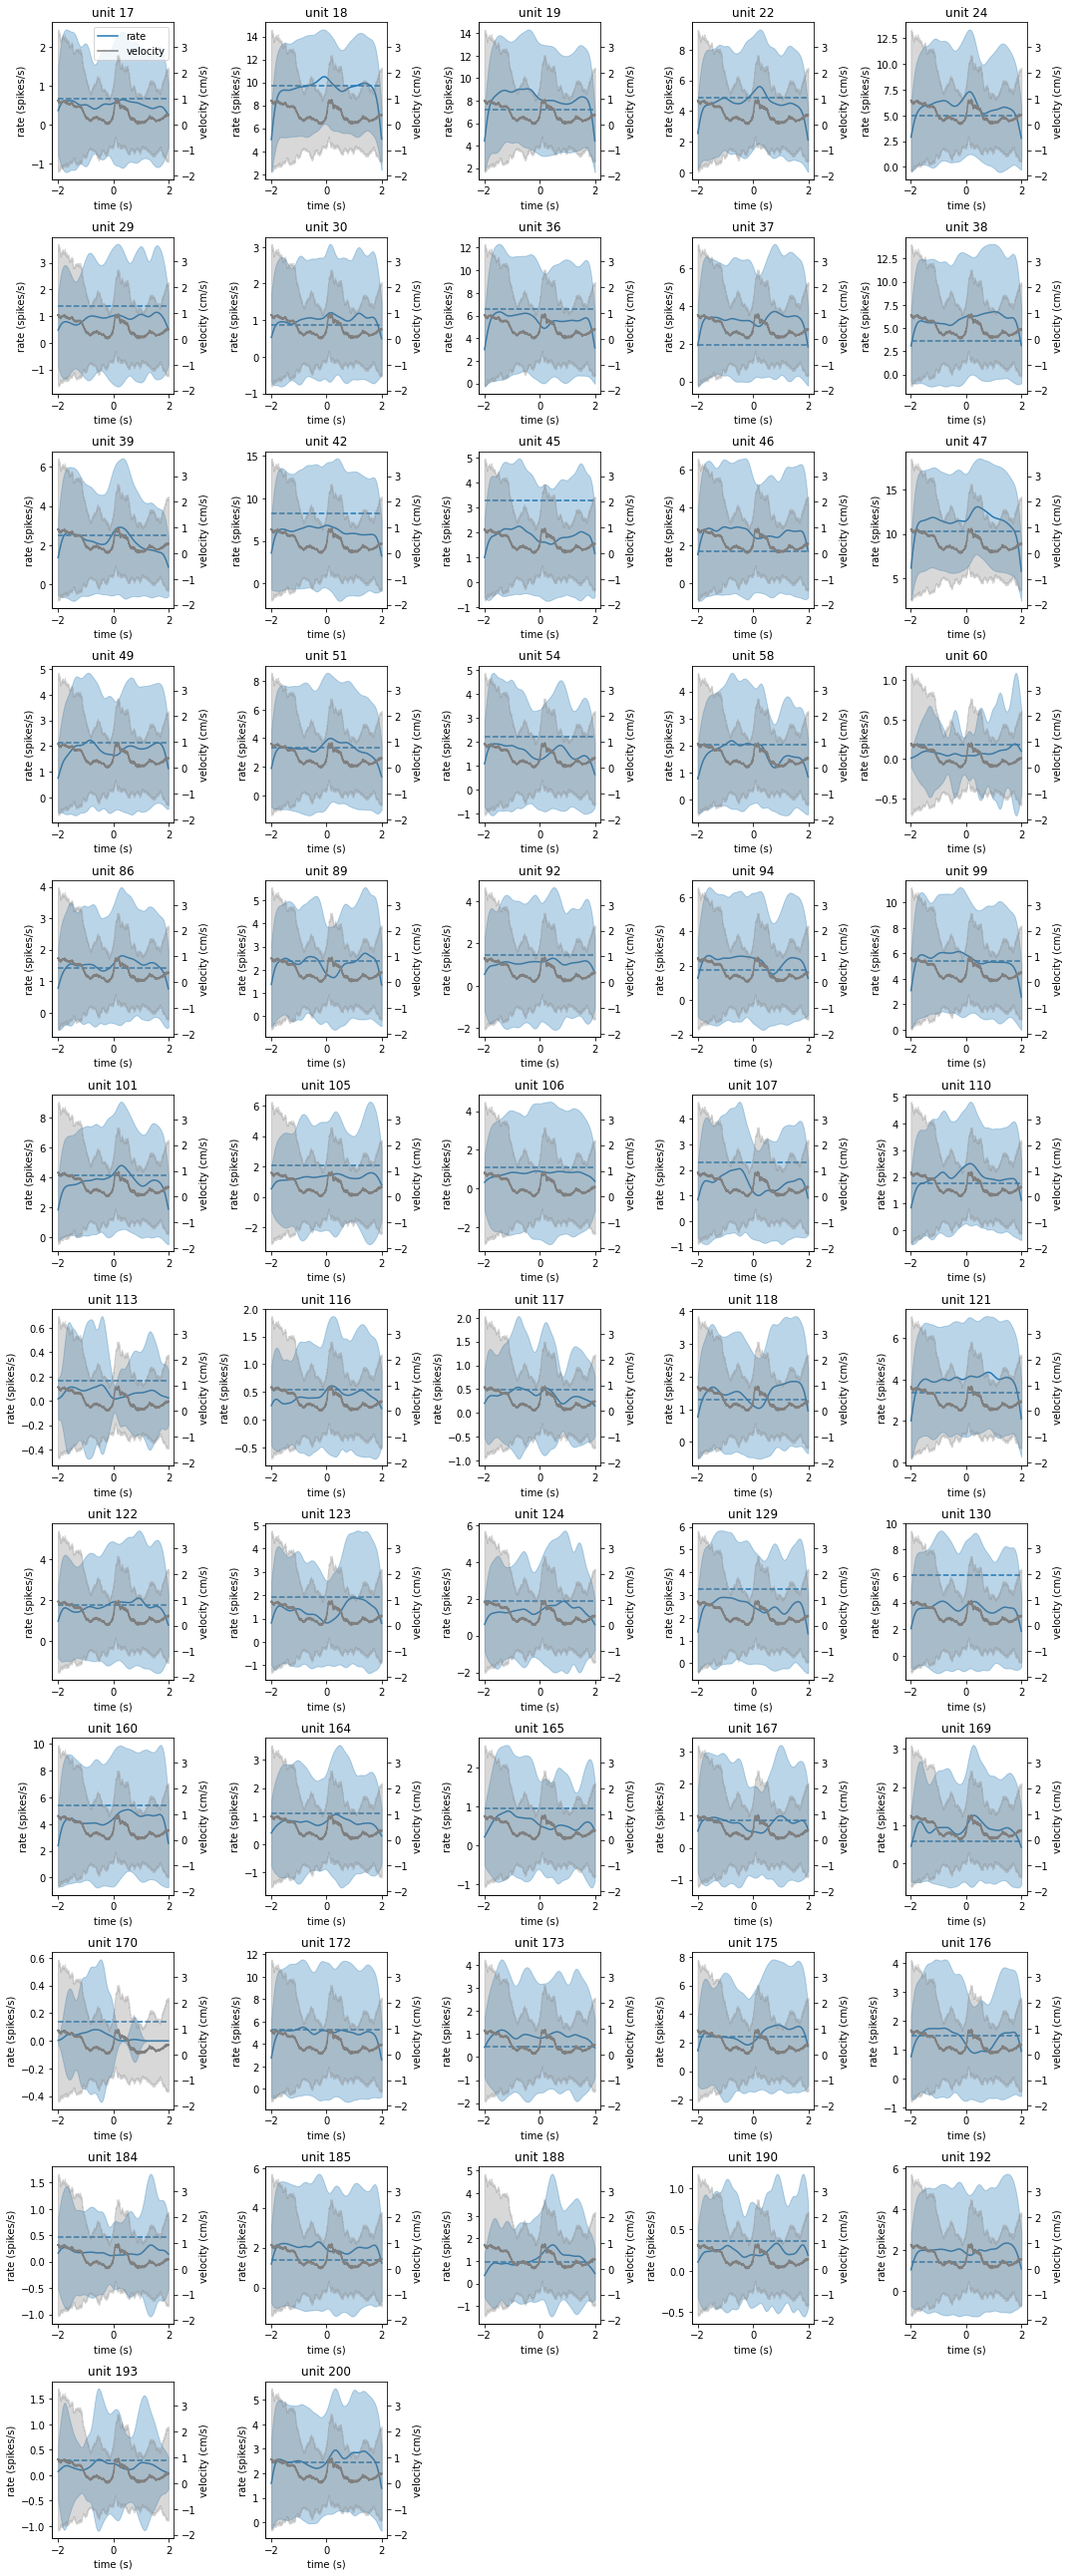

In [56]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})

# Plot PSTH
plotter.plot_psth(counts=np.mean(f_smooth, axis=1),
                  bins=bins,
                  dt_bin=dt_bin,
                  err=np.std(f_smooth, axis=1),
                  labels=cluster_labels,
                  metrics=cluster_metrics,
                  color='C0',
                  label='rate')

# Plot time-aligned wheel velocity
plotter.add_trace(t_wheel_reward, 
                   np.mean(v_wheel_reward, axis=0), 
                   err=np.std(v_wheel_reward, axis=0), 
                   twinx=True, 
                   y_label='velocity (cm/s)', 
                   all_axes=True,
                   color='C7',
                   label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False)

# Save figure
plt.savefig(results_dir + 'peri_reward_activity.pdf')

#### Compare reward sizes

In [57]:
r = sess.f['UntitledRewarduL']['Data'][0, :]
r = r[r > 0]

r_bins = np.array([2.0, 8.0, 12.0])

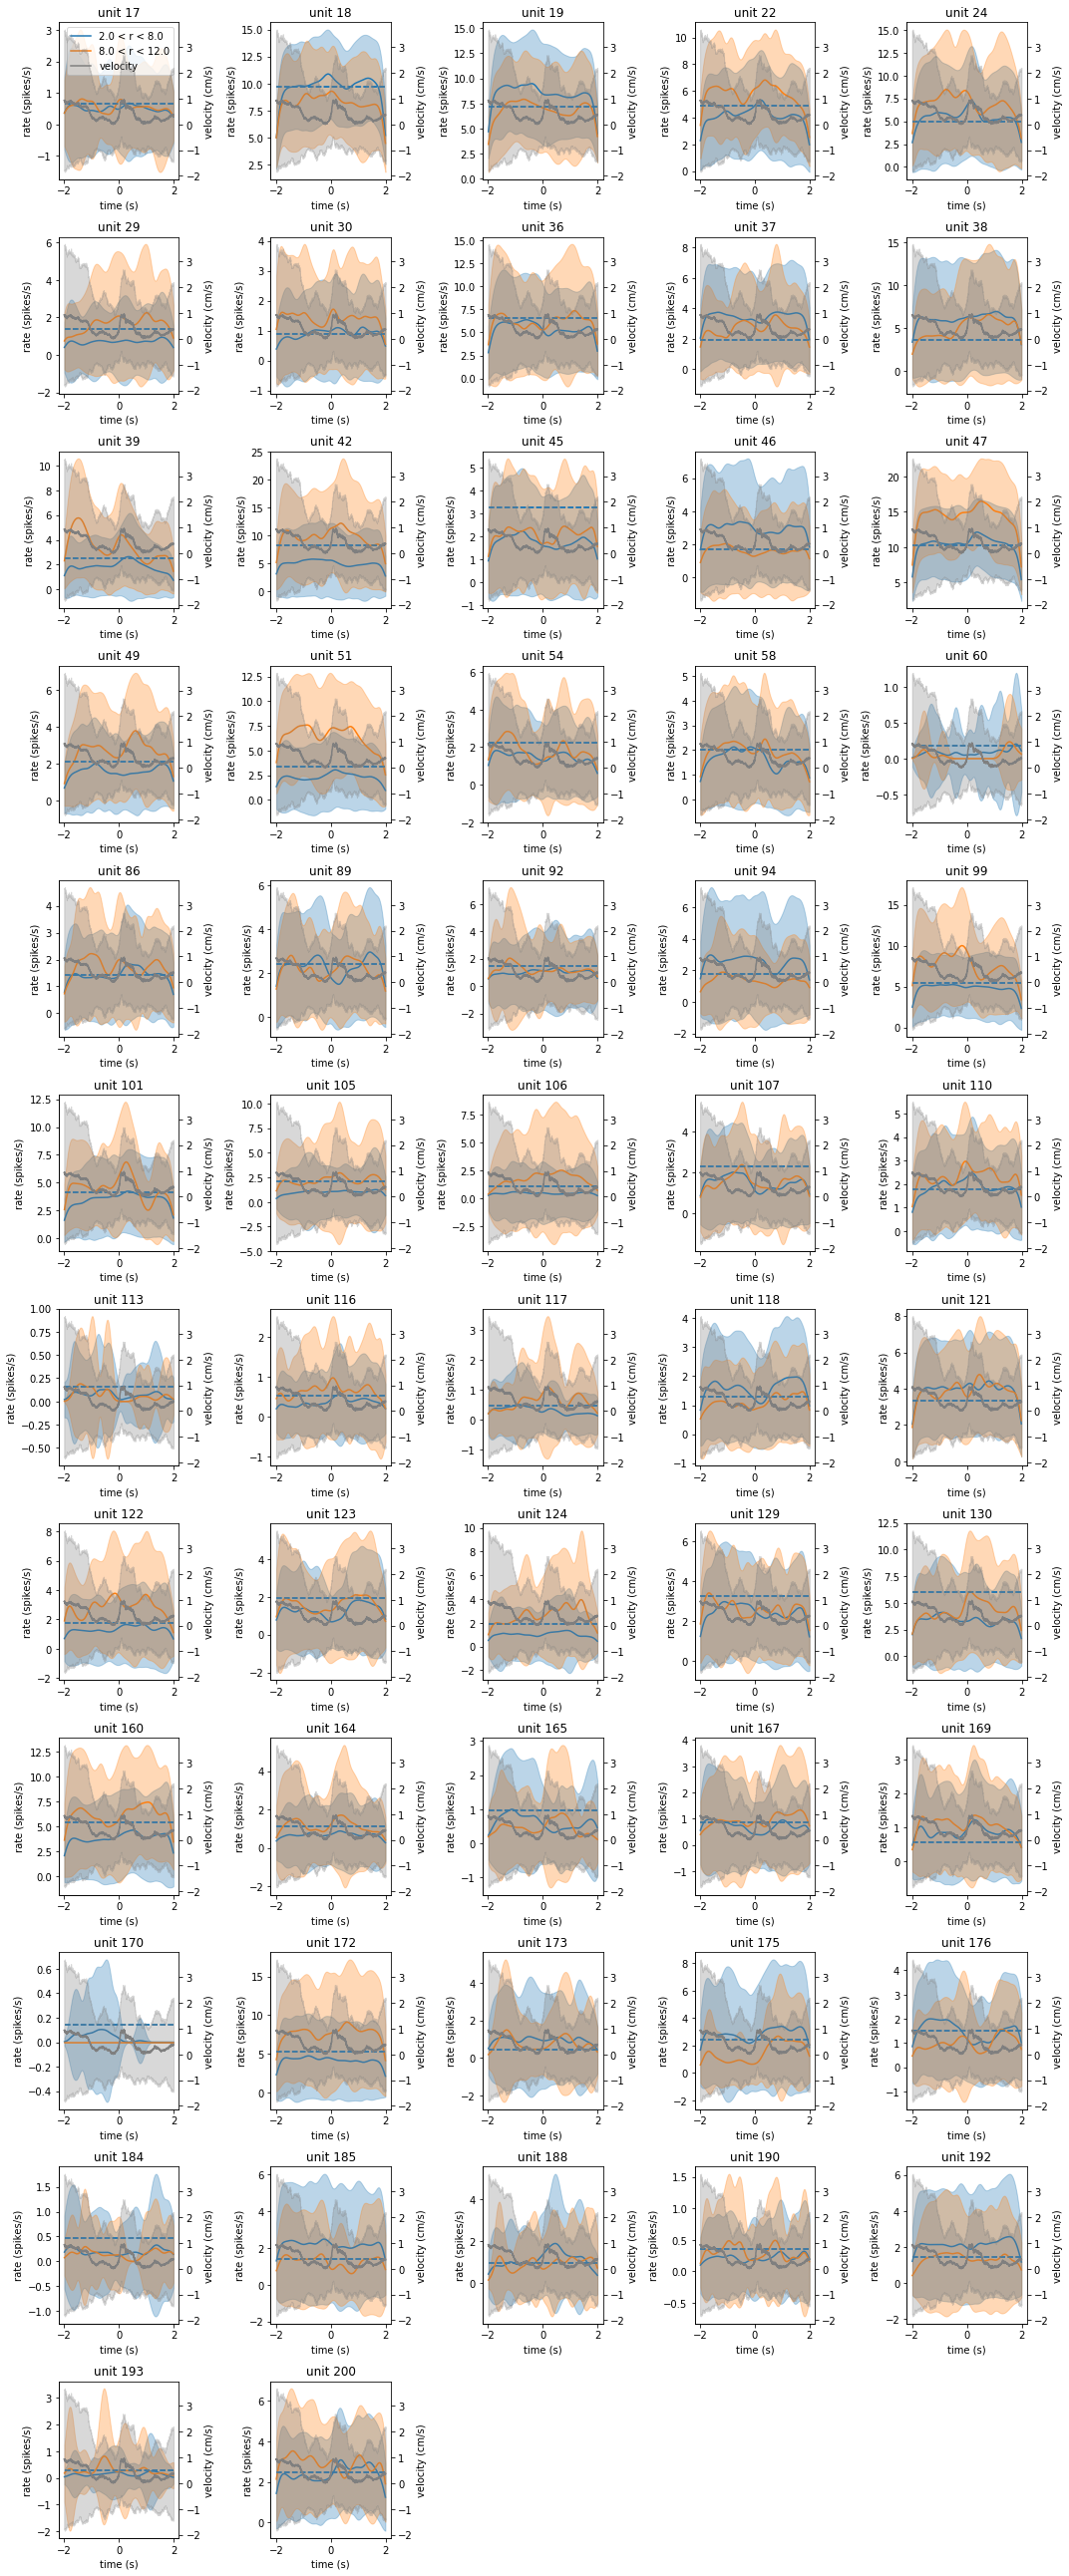

In [68]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})

# Plot PSTH
for i in range(1, r_bins.shape[0]):
    # Get corresponding idx (include border cases)
    if i == 1:
        gt = lambda x, y: x >= y
    else:
        gt = lambda x, y: x > y
    lt = lambda x, y: x <= y
    idx = np.logical_and(gt(r, r_bins[i-1]), lt(r, r_bins[i]))
    
    # Plot PSTH
    plotter.plot_psth(counts=np.mean(f_smooth[:, idx, :], axis=1),
                      bins=bins,
                      dt_bin=dt_bin,
                      err=np.std(f_smooth[:, idx, :], axis=1),
                      labels=cluster_labels,
                      metrics=cluster_metrics,
                      #color='C0',
                      label='%.1f < r < %.1f' % (r_bins[i-1], r_bins[i]),
                      new_fig=(i==1))

# Plot time-aligned wheel velocity
plotter.add_trace(t_wheel_reward, 
                  np.mean(v_wheel_reward, axis=0), 
                  err=np.std(v_wheel_reward, axis=0), 
                  twinx=True, 
                  y_label='velocity (cm/s)', 
                  all_axes=True,
                  color='C7',
                  label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False)

# Save figure
plt.savefig(results_dir + 'peri_reward_activity_binned.pdf')

### Peri-lick activity <a id="peri-lick"></a>

#### Settings

In [70]:
window = [-2.0, 2.0] # window around entering decision
dt_bin = 0.020 # bin size (s)
min_dt_lick = abs(max(window))
min_dt_motor = abs(max(window))

#### Get firing rates around reward

In [71]:
# Get reward times
print('Getting reward times...', end=' ')
t_motor = sess.get_motor_times()
print('done.')

# Get lick times
print('Getting lick times...', end=' ')
t_lick = analysis.get_lick_decisions(sess, min_interval=1.0)
print('done.')

# Session statistics
print('Number of rewards: %d' % t_motor.shape[0])
print('Number of licks: %d' % t_lick.shape[0])

# Filter by window size (licks already filtered)
idx_keep = np.ones(t_motor.shape, dtype=np.bool)
for i in range(t_motor.shape[0]-1):
    if idx_keep[i] and (t_motor[i+1] - t_motor[i]) < min_dt_motor:
        idx_keep[i+1] = False
t_motor = t_motor[idx_keep]

# Keep only rewards with clearly associated licks
idx_keep = util.in_interval(t_lick, t_motor - 0.10, t_motor, query='interval').astype(np.bool)
if np.sum(idx_keep > 1):
    raise UserWarning('Multiple licks associated with same reward.')
t_motor = t_motor[idx_keep]

# Separate rewarded and unrewarded licks
idx_reward = util.in_interval(t_lick, t_motor - 0.10, t_motor, query='event').astype(np.bool)
t_lick_reward = t_lick[idx_reward]
t_lick_empty = t_lick[~idx_reward]

print('Found %d analyzable reward times.' % len(t_motor))
print('%d rewarded licks, %d unrewarded licks' % (t_lick_reward.shape[0], t_lick_empty.shape[0]))

Getting reward times... done.
Getting lick times... done.
Number of rewards: 266
Number of licks: 414
Found 215 analyzable reward times.
215 rewarded licks, 199 unrewarded licks


In [72]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_lick_reward,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin_reward = n_bin / dt_bin
f_smooth_reward = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.513 seconds)
Processing unit 18 (2 of 57)... done. (5.610 seconds)
Processing unit 19 (3 of 57)... done. (4.193 seconds)
Processing unit 22 (4 of 57)... done. (2.770 seconds)
Processing unit 24 (5 of 57)... done. (2.626 seconds)
Processing unit 29 (6 of 57)... done. (1.053 seconds)
Processing unit 30 (7 of 57)... done. (0.712 seconds)
Processing unit 36 (8 of 57)... done. (3.541 seconds)
Processing unit 37 (9 of 57)... done. (1.727 seconds)
Processing unit 38 (10 of 57)... done. (1.992 seconds)
Processing unit 39 (11 of 57)... done. (1.374 seconds)
Processing unit 42 (12 of 57)... done. (4.652 seconds)
Processing unit 45 (13 of 57)... done. (1.719 seconds)
Processing unit 46 (14 of 57)... done. (1.569 seconds)
Processing unit 47 (15 of 57)... done. (6.210 seconds)
Processing unit 49 (16 of 57)... done. (1.809 seconds)
Processing unit 51 (17 of 57)... done. (1.906 seconds)
Processing unit 54 (18 of 57)... done. (1.809 seconds)
Processing unit 58 

../python/ephys.py:489: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  k_i = k(idx)[[np.newaxis]*a + [slice(None)] + [np.newaxis]*b]
../python/ephys.py:490: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x_smooth[slc] = np.sum(k_i * x, axis=axis)


In [73]:
# Get binned spike counts
n_bin, bins = ephys.get_spike_counts(firings=firings,
                                     t_firings=t_firings,
                                     t_stimulus=t_lick_empty,
                                     dt_bin=dt_bin,
                                     t_window=window,
                                     labels=cluster_labels,
                                     verbose=True)

# Smooth spike counts
n_smooth = ephys.smooth_spike_counts(counts=n_bin,
                                     dt_bin=dt_bin,
                                     method='kernel',
                                     axis=-1,
                                     kernel=kernel)

# Convert to firing rates
f_bin_empty = n_bin / dt_bin
f_smooth_empty = n_smooth / dt_bin

Processing unit 17 (1 of 57)... done. (0.461 seconds)
Processing unit 18 (2 of 57)... done. (5.075 seconds)
Processing unit 19 (3 of 57)... done. (3.849 seconds)
Processing unit 22 (4 of 57)... done. (2.555 seconds)
Processing unit 24 (5 of 57)... done. (2.432 seconds)
Processing unit 29 (6 of 57)... done. (0.970 seconds)
Processing unit 30 (7 of 57)... done. (0.660 seconds)
Processing unit 36 (8 of 57)... done. (3.208 seconds)
Processing unit 37 (9 of 57)... done. (1.551 seconds)
Processing unit 38 (10 of 57)... done. (1.843 seconds)
Processing unit 39 (11 of 57)... done. (1.264 seconds)
Processing unit 42 (12 of 57)... done. (4.295 seconds)
Processing unit 45 (13 of 57)... done. (1.561 seconds)
Processing unit 46 (14 of 57)... done. (1.398 seconds)
Processing unit 47 (15 of 57)... done. (5.422 seconds)
Processing unit 49 (16 of 57)... done. (1.569 seconds)
Processing unit 51 (17 of 57)... done. (1.689 seconds)
Processing unit 54 (18 of 57)... done. (1.671 seconds)
Processing unit 58 

In [74]:
# Save firing rates
print('Saving firings rates...', end=' ')
d = {'f_bin_reward': f_bin_reward,
     'f_smooth_reward': f_smooth_reward,
     'f_bin_empty': f_bin_empty,
     'f_smooth_empty': f_smooth_empty,
     'bins': bins,
     'labels': cluster_labels}
np.save(results_dir + 'firing_rates_lick.npy', d)
print('done.')

Saving firings rates... done.


#### Get time-aligned data
This should include wheel velocity and pupil diameter, when both become available.

Note: These are estimated because the wheel data is not sampled uniformly. However, getting exact times across multiple windows is difficult, because each sample may be off by +/- 1 ms.

In [75]:
# Get raw velocity traces and timestamps corresponding to stimulus windows
t_wheel_reward, v_wheel_reward = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_lick_reward, 
                               window=window, 
                               fs=fs_wheel)

t_wheel_empty, v_wheel_empty = \
    util.get_peristimulus_data(v_wheel, 
                               t_wheel, 
                               t_lick_empty, 
                               window=window, 
                               fs=fs_wheel)

#### Plot firing rates
Plot the animal velocity on the same plot as firing rates above. Additionally, compare with stop/go occurences in between patches to see if same peak activity occurs in absence of patch-leaving decision.

TODO: maybe use autocorrelation coefficient to search for non-randomness in curves?

In [76]:
# Load firing data
print('Loading firing data...', end=' ')
d = np.load(results_dir + 'firing_rates_lick.npy')[()]
f_smooth_reward = d.pop('f_smooth_reward')
f_smooth_empty = d.pop('f_smooth_empty')
bins = d.pop('bins')
cluster_labels = d.pop('labels')
print('done.')

Loading firing data... done.


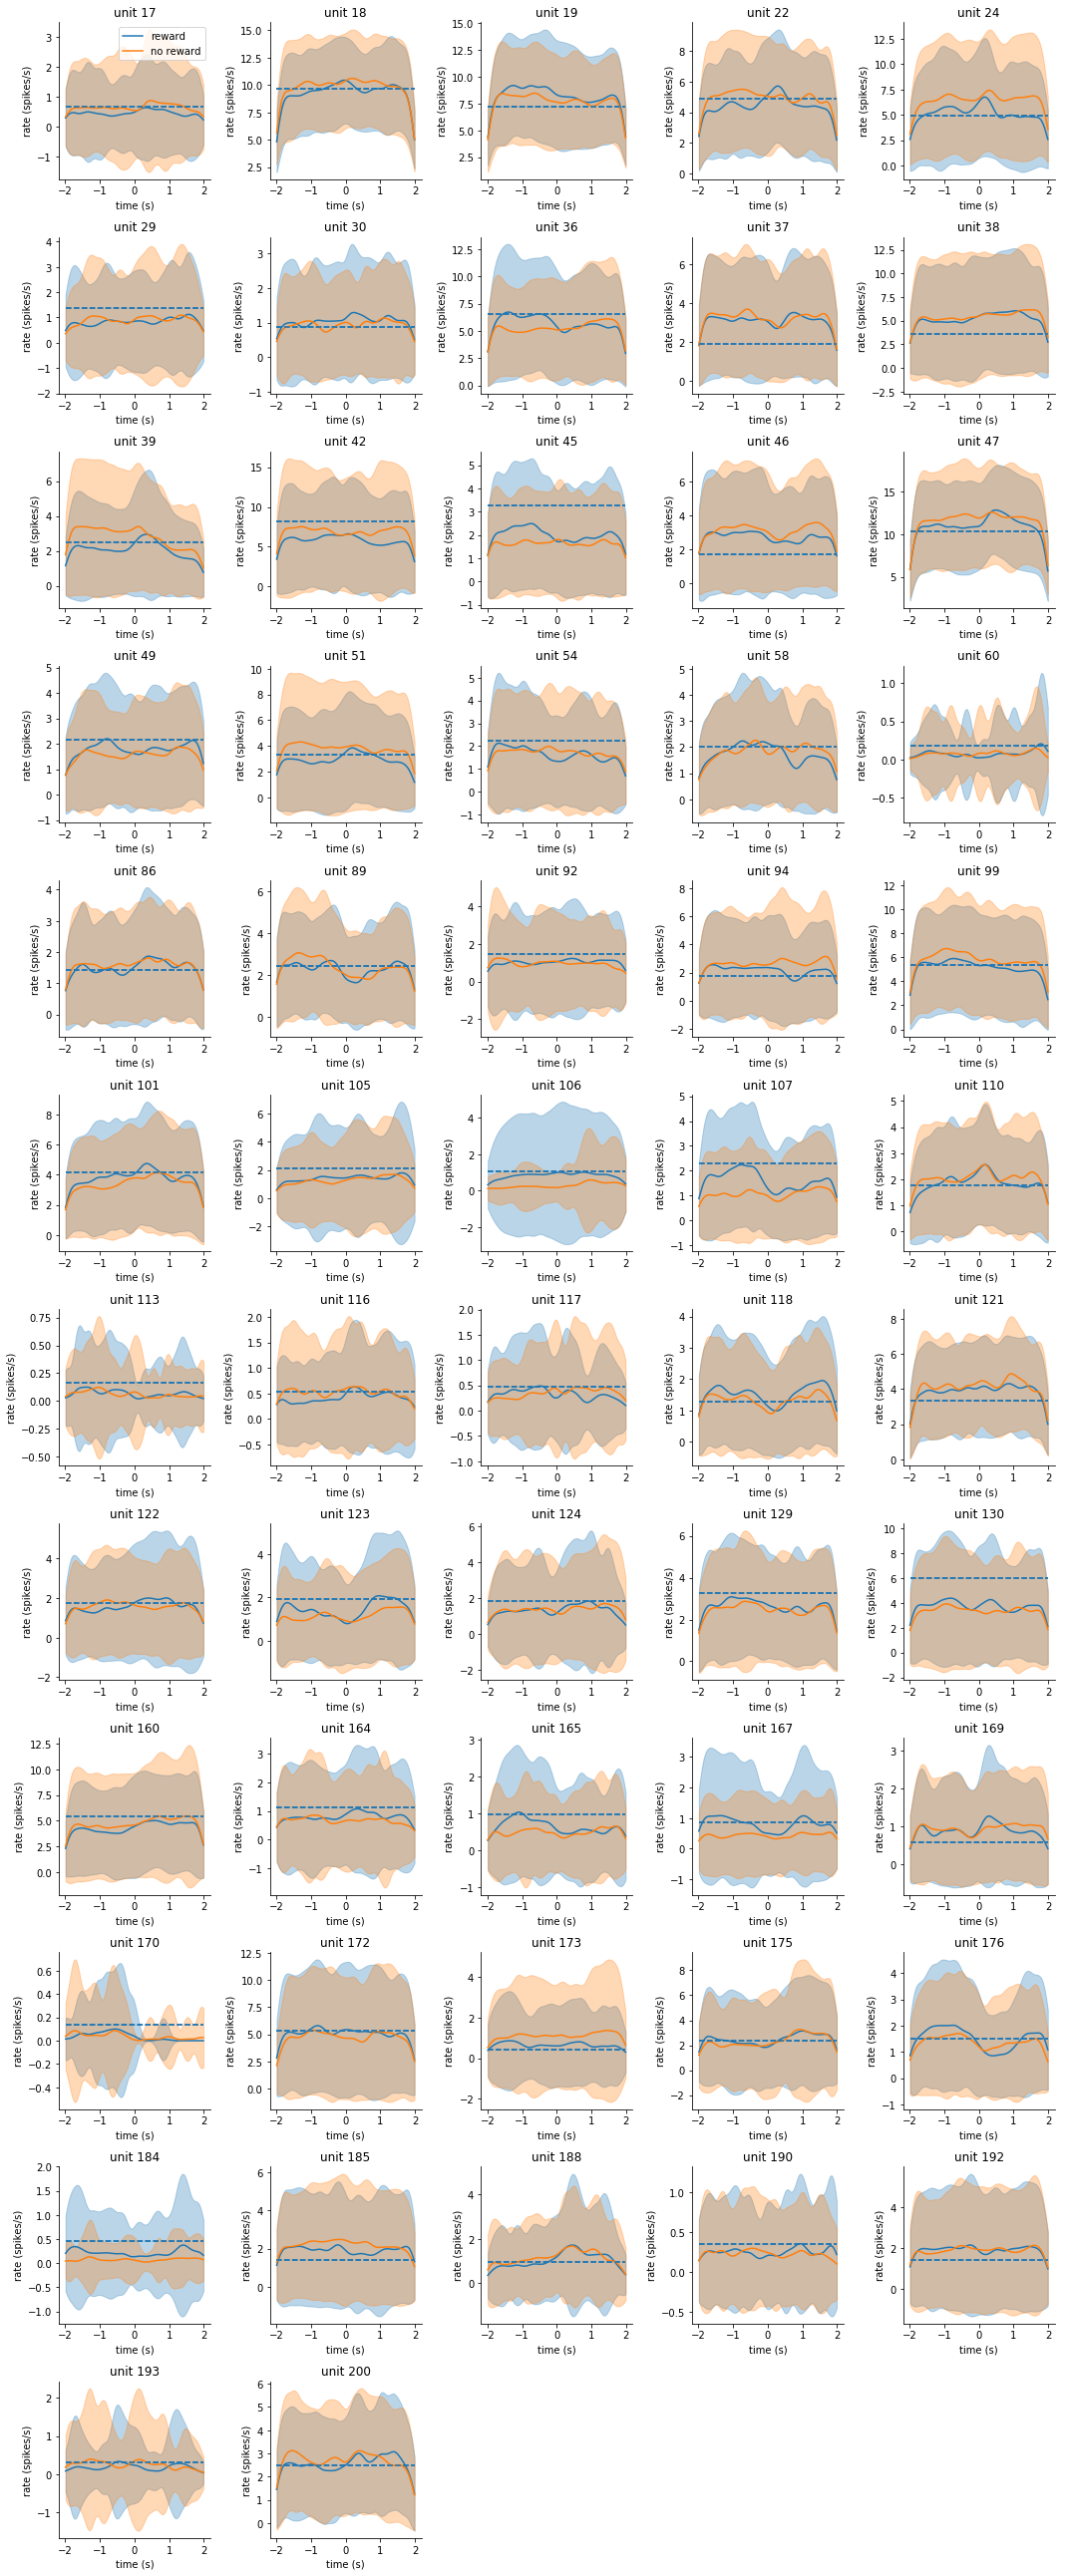

In [77]:
# Plot settings
matplotlib.rcParams.update({'font.size': 10})
    
# Plot PSTH of rewarded licks
plotter.plot_psth(counts=np.mean(f_smooth_reward, axis=1),
                  bins=bins,
                  dt_bin=dt_bin,
                  err=np.std(f_smooth_reward, axis=1),
                  labels=cluster_labels,
                  metrics=cluster_metrics,
                  color='C0',
                  label='reward',
                  new_fig=True)

# Plot PSTH of unrewarded licks
plotter.plot_psth(counts=np.mean(f_smooth_empty, axis=1),
                  bins=bins,
                  dt_bin=dt_bin,
                  err=np.std(f_smooth_empty, axis=1),
                  labels=cluster_labels,
                  metrics=cluster_metrics,
                  color='C1',
                  label='no reward',
                  new_fig=False)

# Plot time-aligned wheel velocity
#plotter.add_trace(t_wheel_reward, 
#                  np.mean(v_wheel_reward, axis=0), 
#                  err=np.std(v_wheel_reward, axis=0), 
#                  twinx=True, 
#                  y_label='velocity (cm/s)', 
#                  all_axes=True,
#                  color='C7',
#                  label='velocity')

# Add legend to first axis
plotter.set_current_axis([0, 0])
plotter.add_legend(all_axes=False)

# Save figure
plt.savefig(results_dir + 'peri_lick_activity.pdf')

### Individual unit analysis <a id="individual-unit"></a>

#### Settings

In [166]:
# Select units
labels = np.array([18, 105, 123, 160, 107, 130, 167, 175]) # first four = increased, last four = decreased with patch exit

# matplotlib params
matplotlib.rcParams.update({'font.size': 22})

#### Generate plots

In [167]:
# Place label order of metrics file in array for easy indexing
metrics_labels = np.zeros(len(cluster_metrics['clusters']), dtype=np.int32)
for i, cluster in enumerate(cluster_metrics['clusters']):
    metrics_labels[i] = cluster['label']

# Load data
print('Loading data...', end=' ')
data_leave = np.load(results_dir + 'firing_rates_leave.npy')[()]
data_enter = np.load(results_dir + 'firing_rates_enter.npy')[()]
data_reward = np.load(results_dir + 'firing_rates_reward.npy')[()]
print('done.')

# Placeholder arrays
data_labels = []
t = []
f_smooth_mean = []
f_smooth_std = []
names = ['leave', 'enter', 'reward']

# Create arrays for patch leaving
print('Preprocessing data...', end=' ')
for data in [data_leave, data_enter, data_reward]:
    data_labels.append(data['labels'])
    bins = data['bins']
    dt_bin = bins[1] - bins[0]
    t.append(bins[:-1] + 0.5*dt_bin)
    f_smooth = convolve(data['f_bin'], kernel, axis=-1)
    f_smooth_mean.append(np.mean(f_smooth, axis=1))
    f_smooth_std.append(np.std(f_smooth, axis=1))
print('done.')
    
for i, label in enumerate(labels):
    print('Processing unit %d (%d of %d)...' % (label, i+1, len(labels)), end=' ')
    
    # Set up directory to save plots
    label_dir = results_dir + ('unit_%d/' % label)
    if not os.path.isdir(label_dir):
        os.mkdir(label_dir)
        
    # Find index in cluster metrics and data
    l = np.where(metrics_labels == label)[0][0]
    idx = []
    for data_labels_ in data_labels:
        idx.append(np.where(data_labels_ == label)[0][0])
    
    # Plot and save activity
    it = zip(idx, t, f_smooth_mean, f_smooth_std, names)
    for j, [idx_, t_, f_, f_std_, name_] in enumerate(it):    
        # Create new figure
        fig, ax = plt.subplots(figsize=(15, 15))
        
        # Plot smoothed firing rate within window
        ax.plot(t_, f_[idx_, :])
        err = f_std_[idx_, :] # std
        ax.fill_between(t_, 
                        y1=f_[idx_, :]-err, 
                        y2=f_[idx_, :]+err,
                        alpha=0.2)

        # Plot average firing rate across session
        rate = cluster_metrics['clusters'][l]['metrics']['firing_rate']
        ax.plot(np.array([t_[0], t_[-1]]), np.array([rate]*2),
                linestyle='--', color='black')

        # Axis settings
        ax.set_title('unit %d' % label)
        ax.set_xlabel('time (s)')
        ax.set_ylabel('rate (spikes/s)')
        ylim = ax.get_ylim()
        ax.set_ylim([-0.05*abs(ylim[1]), ylim[1]])
        
        # Save figure
        plt.savefig(label_dir + 'peri_%s_activity.pdf' % name_)
        
        plt.close()
    
    print('done.')

Loading data... done.
Preprocessing data... done.
Processing unit 18 (1 of 8)... done.
Processing unit 105 (2 of 8)... done.
Processing unit 123 (3 of 8)... done.
Processing unit 160 (4 of 8)... done.
Processing unit 107 (5 of 8)... done.
Processing unit 130 (6 of 8)... done.
Processing unit 167 (7 of 8)... done.
Processing unit 175 (8 of 8)... done.


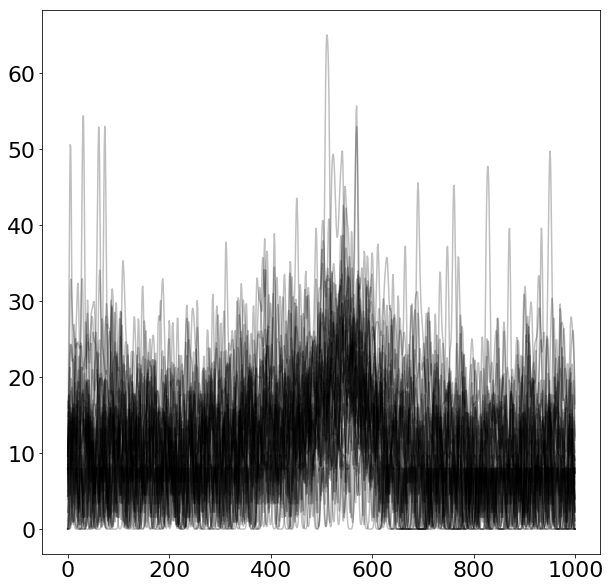

In [151]:
f_bin = data_leave['f_bin']
f_smooth = convolve(f_bin, kernel, axis=-1)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(f_smooth.shape[1]):
    ax.plot(f_smooth[1, i, :], color='black', alpha=0.25)
    
plt.savefig('/home/james/Desktop/traces.eps', dpi=1000)

## LFP analysis <a id="lfp-analysis"></a>

In [247]:
f = open(timeseries_filepath, 'rb')
header_length = 0

# First 32 bits = signed integer indicating data type
code, = struct.unpack('i', f.read(4))
header_length += 4

# Second 32 bits: number of bytes per entry
entry_size, = struct.unpack('i', f.read(4))
header_length += 4

# Third 32 bits: number of dimensions
n_dims, = struct.unpack('i', f.read(4))
header_length += 4

# Next 32*n_dims bits: size of each dimension
shape = np.zeros(n_dims, dtype=np.int64)
for i in range(n_dims):
    shape[i], = struct.unpack('i', f.read(4))
    header_length += 4
print('Number of channels: %d' % shape[0])
print('Number of data points: %d' % shape[1])

# Determine data type from code
if code == -3: # float32
    n_bytes = 4
    format_char = 'f'
elif code == -4: # int16
    n_bytes = 2
    format_char = 'h'
elif code == -5: # int32
    n_bytes = 4
    format_char = 'i'
elif code == -6: # uint16
    n_bytes = 2
    format_char = 'H'
elif code == -7: # double
    n_bytes = 8
    format_char = 'd'
elif code == -8: # uint32
    n_bytes = 4
    format_char = 'I'
else:
    raise ValueError('Unknown code (%d).' % code)

Number of channels: 64
Number of data points: 116875200
